# Prepayment/Default/Recovery curves

## Setting Up

This notebook shows pre-payment/default/recovery analysis based on the case study mortgate data (essentially questions 3 - 8). 

A caveat to all of the following analysis is that the data provided by the seller **excluded mortgages that defaulted or were prepaid prior to the seller's acquisition of the "Backbook" on 31 December 2020**. This introduces a certain amount of survivorship bias into the data - there may be mortgages originated before 31 December 2020 that also defaulted/were prepaid before this date, which would not be included in our data. As such, the default/prepayment probabilities derived from "Backbook" mortgages may be too low.

In [1]:
# append root directory to path so we can import from `common` - in reality this would not be
# required as we would store the modules in `common` as some centrally managed library 

import sys
import os

notebook_root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(notebook_root_dir)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick

from common.analytics import (
    get_conditional_prepayment_curve, 
    get_conditional_default_curve, 
    get_recovery_curve, 
    get_smm, 
    get_mdr,
    get_monthly_recovery_prob
)

In [3]:
data = pd.read_csv("../data/processed_case_study_data.csv", index_col=0).reset_index(drop=True)
date_cols = ["date", "date_of_default"]

for d in date_cols:
    data[d] = pd.to_datetime(data[d])

## Conditional prepayment curve

Here we plot two things:
- **SMM** - the "*single month mortality*" ("SMM") is the £ amount that is prepaid in month T as a % of the total outstanding (ie non-prepaid and non-defaulted) balance at the start of month T. Informally, this can be thought of as a kind of "hazard rate" for pre-payment on mortgages, probability of pre-paying in month T given no default/prepayment prior to this.
- **CPR** - the "*conditional pre-payment risk*" ("CPR") is defined as CPR: 1 - (1 - SMM)^12 - intuitively, this is an annualized version of the SMM for that month

Pre-payment risk in mortgages is the risk that a buyer pays off their mortgage ahead of schedule. The cash is then returned to the mortgage holder, who must reinvest it. This is particulary relevant for products with long (or entirely) fixed periods like most US mortgages. A decline in interest rates incentives holders to prepay, and the holder of the security is faced with having to reinvest at the now less attractive rates. 

The most striking features of the charts below are:
1. for both product types, there is a clear spike in SMM and CPR just before reversion; and
2. this impact is much less pronounced for product type 2 than product type 1

This seems unsurprising - the floating rate is less attractive than then fixed rate, and rate after reversion is significantly higher for borrowers on type 1 mortgages than type 2. As such, it makes sense that for both products borrowers who can pre-pay are incentivized to do so, and that this effect would be larger for the type 1 mortgages.

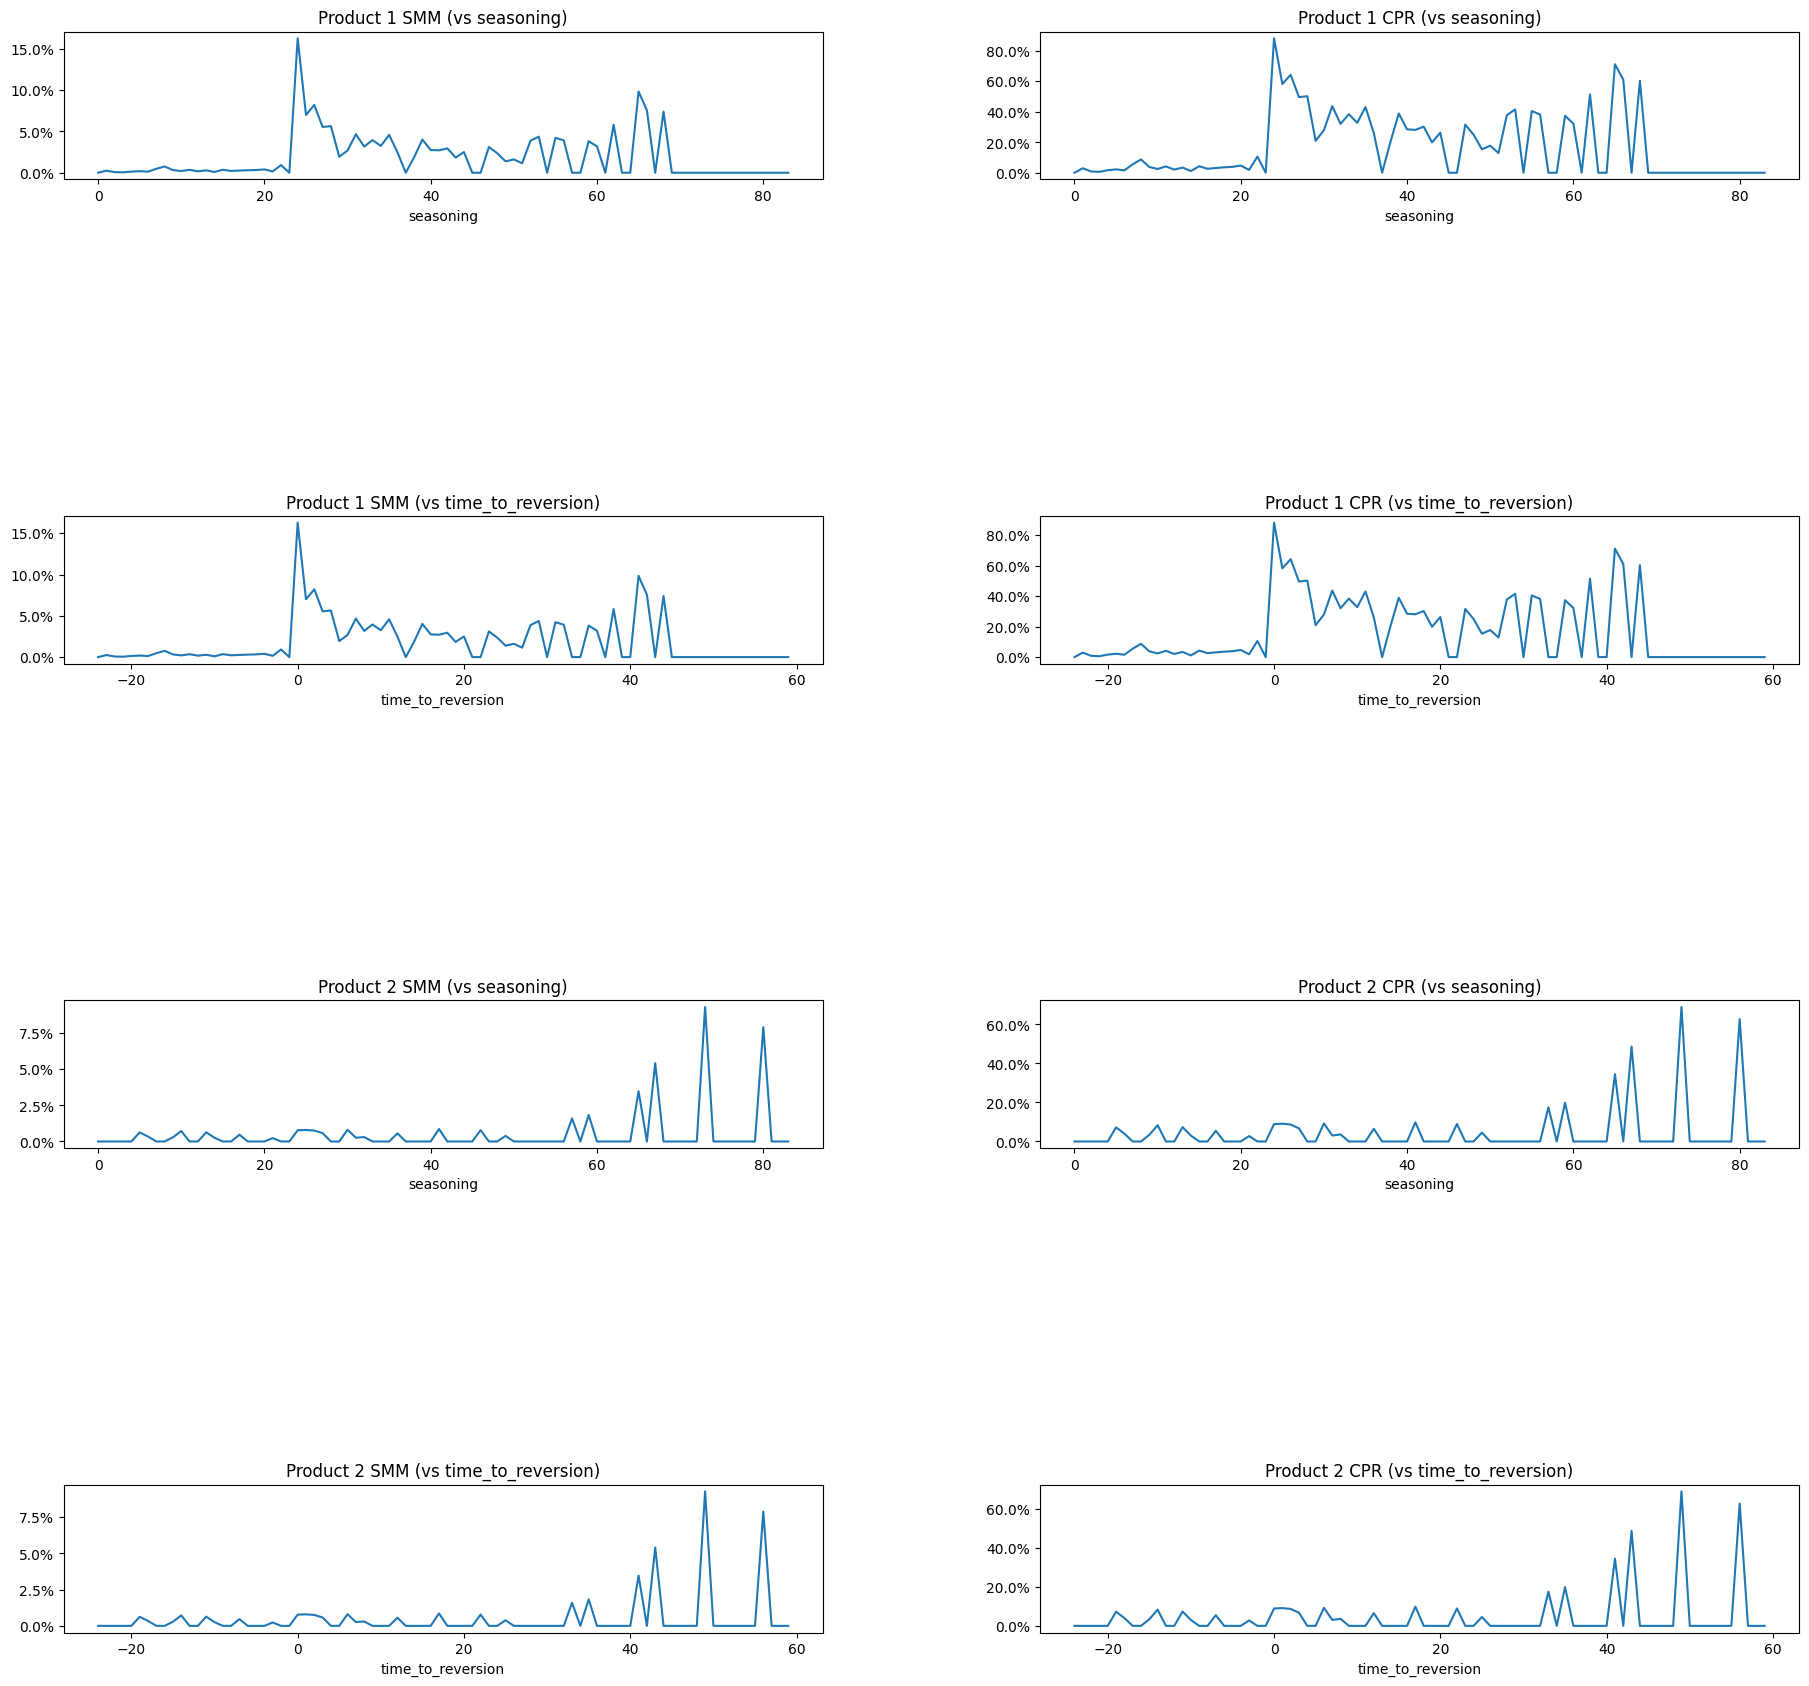

In [17]:
fig, axs = plt.subplots(4, 2)
count = 0

for product in [1, 2]:
    for index_col in ["seasoning", "time_to_reversion"]:
        # get row to plot and data for product type
        row = count // 2
        data_for_product = data[data["product"] == product]

        # calculate and plot SMM
        smm = get_smm(data_for_product, index_col=index_col) * 100   # rescale for charting
        if index_col == "time_to_reversion":
            smm = smm.loc[-24: ]  # cut off long tail of NaNs before 24m
        smm.plot(kind="line", ax=axs[row, 0], title=f"Product {product} SMM (vs {index_col})")
        smm.to_csv(f"../data/product_{product}_by_{index_col}_smm.csv")
        axs[row, 0].yaxis.set_major_formatter(mtick.FuncFormatter('{:.1f}%'.format))
        
        # calculate and plot pre-payment curve
        prepay_curve = get_conditional_prepayment_curve(data_for_product, index_col=index_col) * 100  # rescale for charting
        if index_col == "time_to_reversion":
            prepay_curve = prepay_curve.loc[-24: ]
        prepay_curve.plot(kind="line", ax=axs[row, 1], title=f"Product {product} CPR (vs {index_col})")
        axs[row, 1].yaxis.set_major_formatter(mtick.FuncFormatter('{:.1f}%'.format))

        count += 2

fig.tight_layout()
fig.set_size_inches(20, 20)        

## Conditional default curves

We plot the analogous concepts for defaults:
- **MDR** - the "*monthly default risk*" ("MDR") can be interpreted as the risk of defaulting in month T conditional on having neither defaulted or prepaid prior to that, and is calculated in the same manner as for SMM
- **CDR** - the "*conditional default risk*" ("CDR") similarly has an inuitive interpretation as an annualized version of MDR

Default risk is the risk that a borrower cannot make full payment on their mortgage. In some markets (eg US agency mortgages) the credit risk is borne by an underwriting agence (eg Freddie Mac/Fannie Mae), while in others the buyer of the security will be exposed to this credit risk.

The relationship with seasoning seems somewhat surprising - a buyer who has consistently made payments successfully on the mortgage for a long time may be expected to continue to do so, so inuitively it would decrease as seasoning increases. This may be explained by the switch to higher and variable interest rates post-reversion. This is somewhat supported by the increase in MDR/CDR around and after reversion. An alternative explanation is that credit risk of mortgages in the "Backbook" is generally higher - defaults in this book for low-seasoning would not have made it into our dataset in the first place, whereas defaults that occurred later would have done.

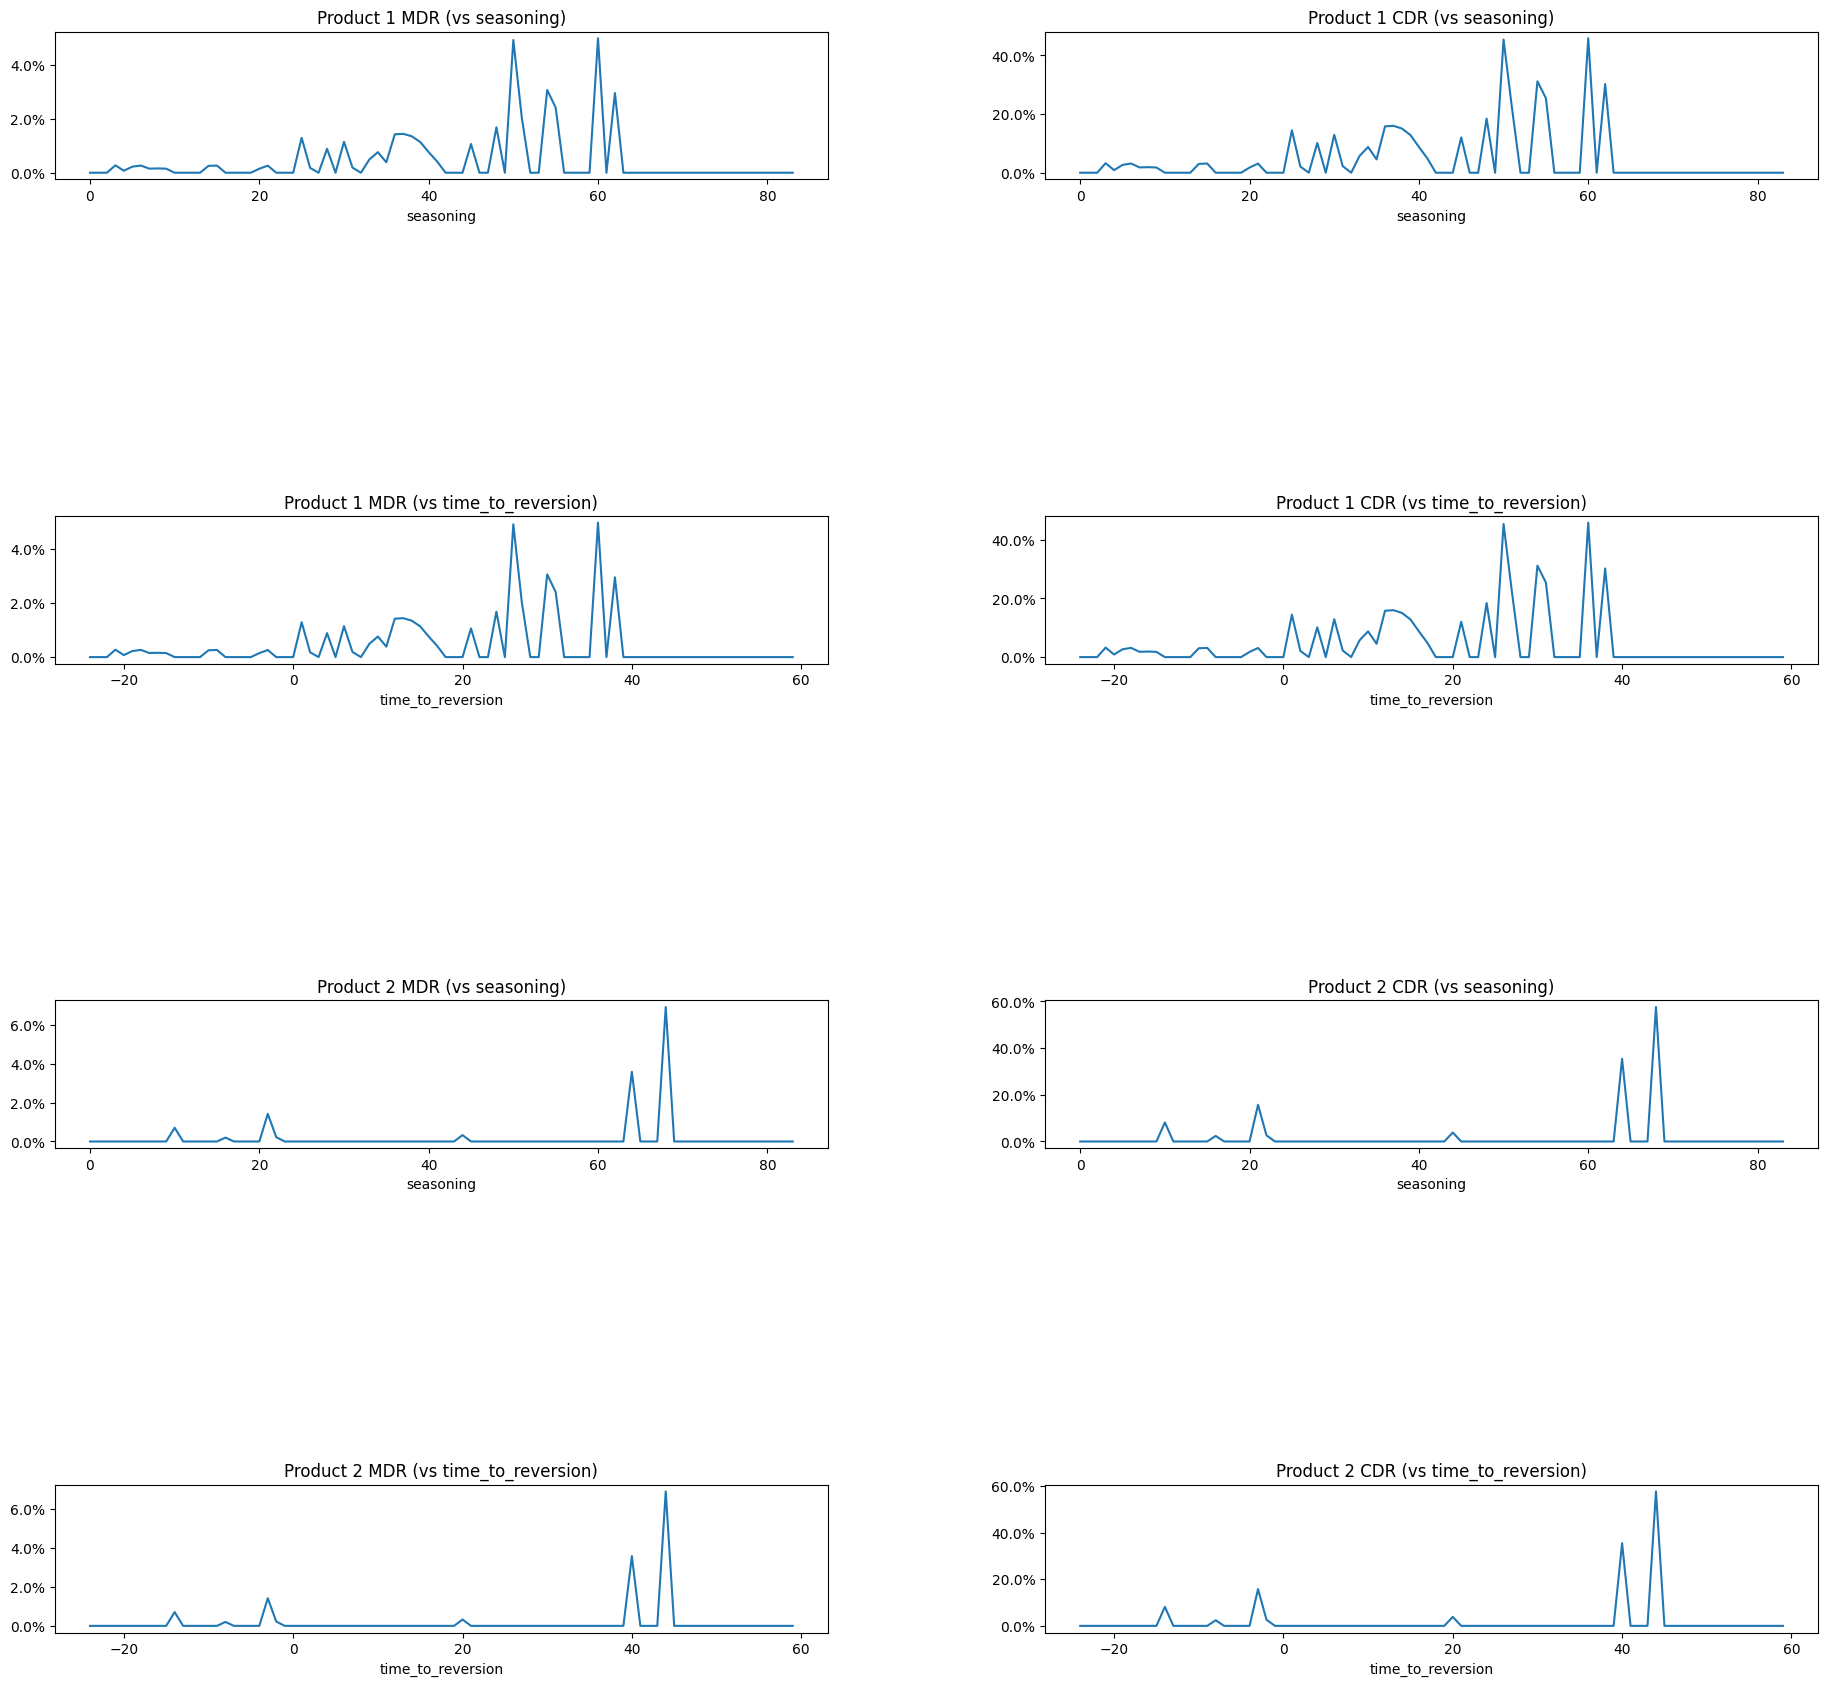

In [18]:
fig, axs = plt.subplots(4, 2)
count = 0

for product in [1, 2]:
    for index_col in ["seasoning", "time_to_reversion"]:
        # get row to plot and data for product type
        row = count // 2
        data_for_product = data[data["product"] == product]

        # calculate and plot MDR
        mdr = get_mdr(data_for_product, index_col=index_col)  * 100  # rescale for charting
        if index_col == "time_to_reversion":
            mdr = mdr.loc[-24: ]  # cut off long tail of NaNs before 24m
        mdr.plot(kind="line", ax=axs[row, 0], title=f"Product {product} MDR (vs {index_col})")
        mdr.to_csv(f"../data/product_{product}_by_{index_col}_mdr.csv")
        axs[row, 0].yaxis.set_major_formatter(mtick.FuncFormatter('{:.1f}%'.format))
        
        # calculate and plot pre-payment curve
        prepay_curve = get_conditional_default_curve(data_for_product, index_col=index_col) * 100  # rescale for charting
        if index_col == "time_to_reversion":
            prepay_curve = prepay_curve.loc[-24: ]  # cut off long tail of NaNs before 24m
        prepay_curve.plot(kind="line", ax=axs[row, 1], title=f"Product {product} CDR (vs {index_col})")
        axs[row, 1].yaxis.set_major_formatter(mtick.FuncFormatter('{:.1f}%'.format))

        count += 2

fig.tight_layout()
fig.set_size_inches(20, 20)        

## Recovery curves

Recovery curves show the expected % of a loss that we expect to recoup, calculated as the cumulative amount paid back by defaulted borrowers (ie borrowers missing at least three payments consecutively) vs the aggregate exposure upon default. Clearly a greater default recovery is preferred for holders of mortgage securities.

The charts show recovery curves for defaults in years 2021 and 2022 (owing to the limitations in the data mentioned in the introduction, these are the only years that we have default data for). It appears that amount recouped levels off after ~10 months post-default. The total amount recovered of 80% is much higher for the 2021 defaults than the 2022 ones. While this could reflect genuinely differing experiences between these cohorts, it is likely a major driver is that (given our data only goes up to Dec 2022) mortgages defaulting in 2022 do not then have a full post-default period in our data where further recoveries may have occurred.

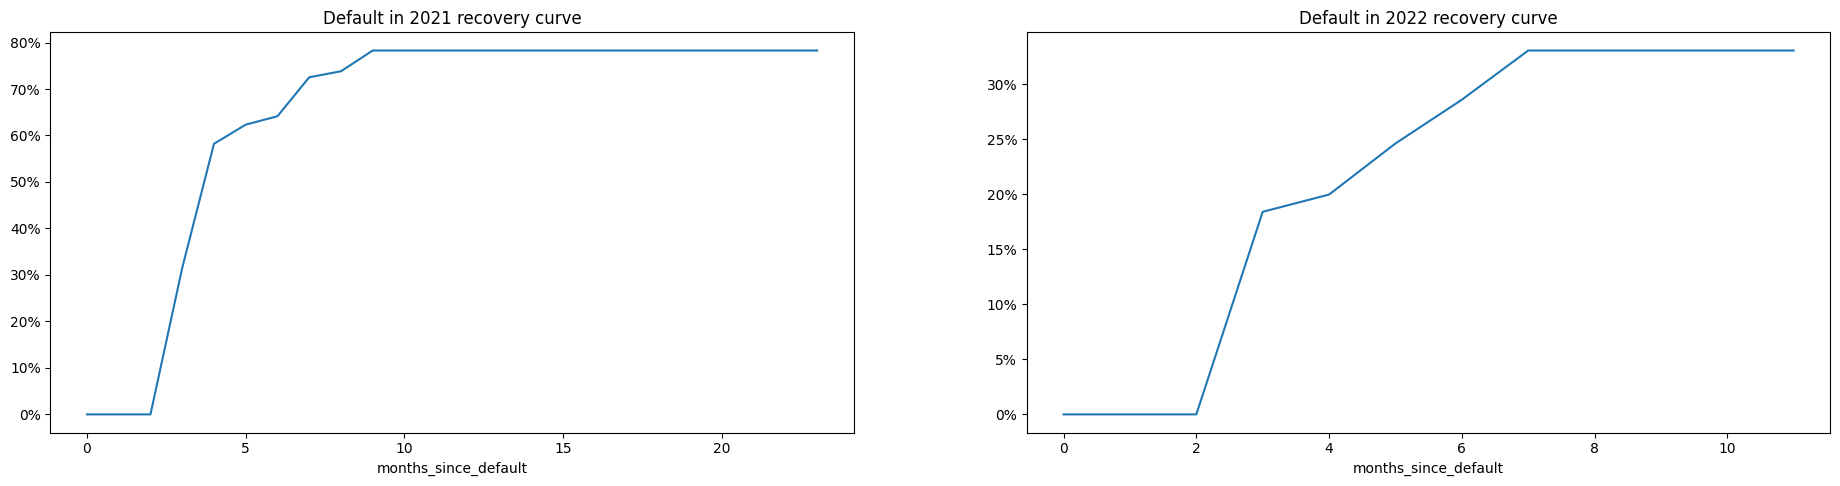

In [19]:
fig, axs = plt.subplots(1, 2)
defaulted_loans_data = data[data["date_of_default"].notnull()].copy()

for i, default_year in enumerate([2021, 2022]):
    default_for_year = defaulted_loans_data[defaulted_loans_data["date_of_default"].dt.year == default_year]
    recovery_curve = get_recovery_curve(default_for_year)  * 100  # rescale for plotting
    recovery_curve.to_csv(f"../data/recovery_curve_{default_year}.csv")
    recovery_curve.plot(kind="line", ax=axs[i], title=f"Default in {default_year} recovery curve")
    axs[i].yaxis.set_major_formatter(mtick.FuncFormatter('{:.0f}%'.format))
    

fig.tight_layout()
fig.set_size_inches(20, 5)

We can also look at the probability of recovery in month T, given no recovery up to that point. I have calculated this simply as the number of loans recovering in month T vs the number in default at the start of the month (as opposed to focussing on the quantum of money recovered). Probabilities look very broadly similar across the two default years, suggesting it is the amount recovered rather than probability that there is a recovery driving the differences above.

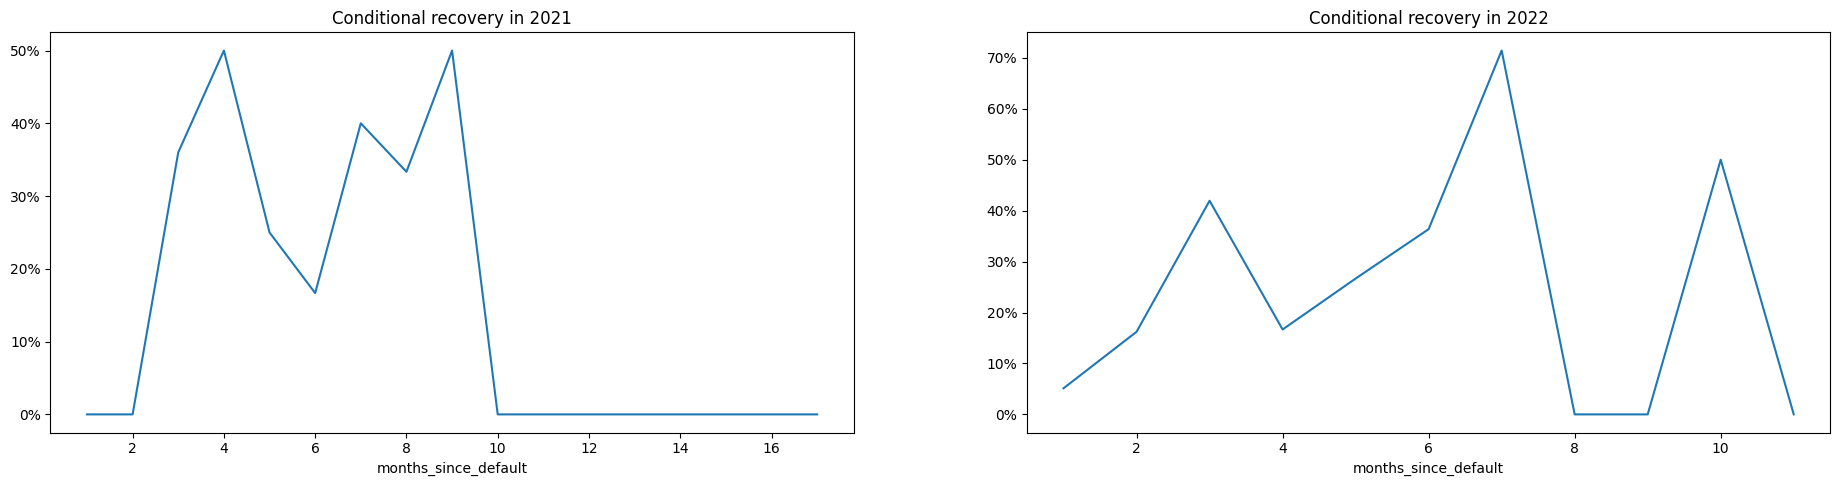

In [12]:
fig, axs = plt.subplots(1, 2)
defaulted_loans_data = data[data["date_of_default"].notnull()].copy()

for i, default_year in enumerate([2021, 2022]):
    default_for_year = defaulted_loans_data[defaulted_loans_data["date_of_default"].dt.year == default_year]
    recovery_prob = get_monthly_recovery_prob(default_for_year)  * 100  # rescale for plotting
    recovery_prob.plot(kind="line", ax=axs[i], title=f"Conditional recovery in {default_year}")
    axs[i].yaxis.set_major_formatter(mtick.FuncFormatter('{:.0f}%'.format))
    

fig.tight_layout()
fig.set_size_inches(20, 5)